In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    #('count', lambda x: x.sample(frac = 1).head(5).shape[0])

    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0])]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
    df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[(df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>0) & (df['ProbVLM']=='False')]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline-not-finetuned' : df_no_finetune, 'baseline-finetuned': df_baseline, 's-clip': df_S_CLIP, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
validation_path = './eval.txt'
df_grouped = prep_and_store_results(validation_path)

['RS.ALL', '0.1', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64', '0']
Lengths {14}
Number of evaluations: 51030
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
51025,Sydney,image_to_text_R@5,10.26,0.1,base,True,5.0,10.0,None,10,0.00005,32
51026,Sydney,image_to_text_R@10,16.10,0.1,base,True,5.0,10.0,None,10,0.00005,32
51027,Sydney,text_to_image_R@1,2.41,0.1,base,True,5.0,10.0,None,10,0.00005,32
51028,Sydney,text_to_image_R@5,9.86,0.1,base,True,5.0,10.0,None,10,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
51025,Sydney,image_to_text_R@5,10.26,0.1,base,True,5.0,10.0,None,10,0.00005,32
51026,Sydney,image_to_text_R@10,16.10,0.1,base,True,5.0,10.0,None,10,0.00005,32
51027,Sydney,text_to_image_R@1,2.41,0.1,base,True,5.0,10.0,None,10,0.00005,32
51028,Sydney,text_to_image_R@5,9.86,0.1,base,True,5.0,10.0,None,10,0.00005,32


value  \
                                                                                                      mean   
method ProbVLM dataset epochs PL        ratio AL.iter bs  lr       AL.epochs metric                          
base   False   RSICD   5      None      0.1   20.0    64  0.000050 5.0       image_to_text_R@1    2.993333   
                                                                             image_to_text_R@10  21.153333   
                                                                             image_to_text_R@5   12.240000   
                                                                             text_to_image_R@1    2.626667   
                                                                             text_to_image_R@10  20.850000   
...                                                                                                    ...   
ours   False   UCM-CLS 35     soft.text 0.1   NaN     64  0.000050 NaN       zeroshot-val-top1   65.557500   
                                                          0.000500 NaN       zeroshot-val-top1    4.812500   
                                                      128 0.000005 NaN       zeroshot-val-top1   59.908889   
                                                          0.000050 NaN       zeroshot-val-top1   68.810000   
                                                          0.000500 NaN       zeroshot-val-top1    4.808889   

                                                                                                           \
                                                                                                      std   
method ProbVLM dataset epochs PL        ratio AL.iter bs  lr       AL.epochs metric                         
base   False   RSICD   5      None      0.1   20.0    64  0.000050 5.0       image_to_text_R@1   0.501431   
                                                                             image_to_text_R@10  1.037176   
                                                                             image_to_text_R@5   1.611583   
                                                                             text_to_image_R@1   0.449704   
                                                                             text_to_image_R@10  0.685493   
...                                                                                                   ...   
ours   False   UCM-CLS 35     soft.text 0.1   NaN     64  0.000050 NaN       zeroshot-val-top1   6.541505   
                                                          0.000500 NaN       zeroshot-val-top1   0.211877   
                                                      128 0.000005 NaN       zeroshot-val-top1   3.114757   
                                                          0.000050 NaN       zeroshot-val-top1   3.476025   
                                                          0.000500 NaN       zeroshot-val-top1   0.187979   

                                                                                                       
                                                                                                count  
method ProbVLM dataset epochs PL        ratio AL.iter bs  lr       AL.epochs metric                    
base   False   RSICD   5      None      0.1   20.0    64  0.000050 5.0       image_to_text_R@1      3  
                                                                             image_to_text_R@10     3  
                                                                             image_to_text_R@5      3  
                                                                             text_to_image_R@1      3  
                                                                             text_to_image_R@10     3  
...                                                                                               ...  
ours   False   UCM-CLS 35     soft.text 0.1   NaN     64  0.000050 NaN       zeroshot-val-top1   

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

method ProbVLM  dataset epochs         PL ratio AL.iter   bs       lr  \
                                                                             
2452   ours   False    RSICD      5  soft.text   0.1     NaN   64  0.00050   
3532   ours   False    RSICD     30  soft.text   0.1     NaN   64  0.00050   
2344   ours   False    RSICD      5   ot.image   0.1     NaN   64  0.00050   
3622   ours   False    RSICD     35  hard.text   0.1     NaN  128  0.00050   
2362   ours   False    RSICD      5   ot.image   0.1     NaN  128  0.00050   
...     ...     ...      ...    ...        ...   ...     ...  ...      ...   
1958   base   False  UCM-CLS      5       None   0.5     NaN   64  0.00005   
2003   base   False  UCM-CLS     15       None   0.7     NaN   64  0.00005   
1959   base   False  UCM-CLS      5       None   0.7     NaN   64  0.00005   
2002   base   False  UCM-CLS     15       None   0.5     NaN   64  0.00005   
1978   base   False  UCM-CLS     10       None   0.7     NaN   64  0.00005   

     AL.epochs             metric    value                  
                                      mean       std count  
2452       5.0  image_to_text_R@1   0.0675  0.045000     4  
3532      30.0  image_to_text_R@1   0.0675  0.045000     4  
2344       5.0  image_to_text_R@1   0.0700  0.060000     9  
3622      35.0  image_to_text_R@1   0.0700  0.039686     9  
2362       5.0  image_to_text_R@1   0.0800  0.030000     9  
...        ...                ...      ...       ...   ...  
1958       5.0  zeroshot-val-top1  77.7550  3.436680     4  
2003      15.0  zeroshot-val-top1  77.9725  3.209884     4  
1959       5.0  zeroshot-val-top1  78.1875  5.256433     4  
2002      15.0  zeroshot-val-top1  78.2875  3.939225     4  
1978      10.0  zeroshot-val-top1  78.3975  3.115032     4  

[7300 rows x 14 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline-finetuned']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_probvlm_AL.groupby(['metric', 'dataset']).tail(3))

method ProbVLM    dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                         
2040   base    True      RSICD      5  None   0.1     5.0  32  0.00005   
2100   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2094   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2171   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2123   base    True     Sydney      5  None   0.1     5.0  32  0.00005   
2177   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2237   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2219   base    True        UCM      5  None   0.1    20.0  32  0.00005   
2243   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2047   base    True      RSICD      5  None   0.1     5.0  32  0.00005   
2101   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2095   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2148   base    True     Sydney      5  None   0.1    10.0  32  0.00005   
2160   base    True     Sydney      5  None   0.1    20.0  32  0.00005   
2172   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2202   base    True        UCM      5  None   0.1    10.0  32  0.00005   
2214   base    True        UCM      5  None   0.1    10.0  32  0.00005   
2238   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2048   base    True      RSICD      5  None   0.1     5.0  32  0.00005   
2096   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2102   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2161   base    True     Sydney      5  None   0.1    20.0  32  0.00005   
2125   base    True     Sydney      5  None   0.1     5.0  32  0.00005   
2179   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2215   base    True        UCM      5  None   0.1    10.0  32  0.00005   
2239   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2245   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2055   base    True      RSICD      5  None   0.1     5.0  32  0.00005   
2097   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2103   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2120   base    True     Sydney      5  None   0.1     5.0  32  0.00005   
2156   base    True     Sydney      5  None   0.1    20.0  32  0.00005   
2174   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2240   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2216   base    True        UCM      5  None   0.1    10.0  32  0.00005   
2246   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2062   base    True      RSICD      5  None   0.1    10.0  32  0.00005   
2104   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2098   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2181   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2127   base    True     Sydney      5  None   0.1     5.0  32  0.00005   
2175   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2247   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2217   base    True        UCM      5  None   0.1    10.0  32  0.00005   
2241   base    True        UCM     10  None   0.1     5.0  32  0.00005   
2063   base    True      RSICD      5  None   0.1    10.0  32  0.00005   
2099   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2105   base    True      RSICD     10  None   0.1     5.0  32  0.00005   
2134   base    True     Sydney      5  None   0.1     5.0  32  0.00005   
2146   base    True     Sydney      5  None   0.1    10.0  32  0.00005   
2176   base    True     Sydney     10  None   0.1     5.0  32  0.00005   
2218   base    True        UCM      5  None   0.1    10.0  32  0.00005   
2242   ba

In [7]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) #

method ProbVLM    dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                         
456    base   False      RSICD     20  None   0.1    20.0  64  0.00005   
408    base   False      RSICD     20  None   0.1     5.0  64  0.00005   
426    base   False      RSICD     20  None   0.1    10.0  64  0.00005   
1029   base   False     Sydney     15  None   0.1    30.0  64  0.00005   
1125   base   False     Sydney     20  None   0.1     5.0  64  0.00005   
1161   base   False     Sydney     20  None   0.1    20.0  64  0.00005   
1761   base   False        UCM     20  None   0.1    10.0  64  0.00005   
1743   base   False        UCM     20  None   0.1     5.0  64  0.00005   
1749   base   False        UCM     20  None   0.1    10.0  64  0.00005   
229    base   False      RSICD     15  None   0.1    10.0  64  0.00005   
421    base   False      RSICD     20  None   0.1    10.0  64  0.00005   
409    base   False      RSICD     20  None   0.1     5.0  64  0.00005   
1048   base   False     Sydney     15  None   0.1    30.0  64  0.00005   
1120   base   False     Sydney     20  None   0.1     5.0  64  0.00005   
1162   base   False     Sydney     20  None   0.1    20.0  64  0.00005   
1624   base   False        UCM     15  None   0.1    20.0  64  0.00005   
1750   base   False        UCM     20  None   0.1    10.0  64  0.00005   
1792   base   False        UCM     20  None   0.1    20.0  64  0.00005   
428    base   False      RSICD     20  None   0.1    10.0  64  0.00005   
458    base   False      RSICD     20  None   0.1    20.0  64  0.00005   
410    base   False      RSICD     20  None   0.1     5.0  64  0.00005   
1133   base   False     Sydney     20  None   0.1    10.0  64  0.00005   
1121   base   False     Sydney     20  None   0.1     5.0  64  0.00005   
1163   base   False     Sydney     20  None   0.1    20.0  64  0.00005   
1451   base   False        UCM     10  None   0.1    20.0  64  0.00005   
1625   base   False        UCM     15  None   0.1    20.0  64  0.00005   
1751   base   False        UCM     20  None   0.1    10.0  64  0.00005   
423    base   False      RSICD     20  None   0.1    10.0  64  0.00005   
411    base   False      RSICD     20  None   0.1     5.0  64  0.00005   
459    base   False      RSICD     20  None   0.1    20.0  64  0.00005   
1122   base   False     Sydney     20  None   0.1     5.0  64  0.00005   
1164   base   False     Sydney     20  None   0.1    20.0  64  0.00005   
1170   base   False     Sydney     20  None   0.1    20.0  64  0.00005   
1746   base   False        UCM     20  None   0.1     5.0  64  0.00005   
1794   base   False        UCM     20  None   0.1    20.0  64  0.00005   
1764   base   False        UCM     20  None   0.1    10.0  64  0.00005   
460    base   False      RSICD     20  None   0.1    20.0  64  0.00005   
424    base   False      RSICD     20  None   0.1    10.0  64  0.00005   
412    base   False      RSICD     20  None   0.1     5.0  64  0.00005   
1123   base   False     Sydney     20  None   0.1     5.0  64  0.00005   
1147   base   False     Sydney     20  None   0.1    10.0  64  0.00005   
1165   base   False     Sydney     20  None   0.1    20.0  64  0.00005   
1669   base   False        UCM     15  None   0.1    30.0  64  0.00005   
1651   base   False        UCM     15  None   0.1    30.0  64  0.00005   
1627   base   False        UCM     15  None   0.1    20.0  64  0.00005   
209    base   False      RSICD     15  None   0.1     5.0  64  0.00005   
461    base   False      RSICD     20  None   0.1    20.0  64  0.00005   
413    base   False      RSICD     20  None   0.1     5.0  64  0.00005   
1052   base   False     Sydney     15  None   0.1    30.0  64  0.00005   
1148   base   False     Sydney     20  None   0.1    10.0  64  0.00005   
1166   base   False     Sydney     20  None   0.1    20.0  64  0.00005   
1766   base   False        UCM     20  None   0.1    10.0  64  0.00005   
1628   ba

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

method ProbVLM    dataset epochs    PL ratio AL.iter   bs       lr  \
                                                                          
516    base   False      RSICD     25  None   0.1     NaN   64  0.00005   
588    base   False      RSICD     35  None   0.1     NaN   64  0.00005   
552    base   False      RSICD     30  None   0.1     NaN   64  0.00005   
1263   base   False     Sydney     30  None   0.1     NaN   64  0.00005   
1281   base   False     Sydney     30  None   0.1     NaN  128  0.00005   
1317   base   False     Sydney     35  None   0.1     NaN  128  0.00005   
1917   base   False        UCM     35  None   0.1     NaN   64  0.00005   
1863   base   False        UCM     25  None   0.1     NaN  128  0.00005   
1881   base   False        UCM     30  None   0.1     NaN   64  0.00005   
553    base   False      RSICD     30  None   0.1     NaN   64  0.00005   
517    base   False      RSICD     25  None   0.1     NaN   64  0.00005   
589    base   False      RSICD     35  None   0.1     NaN   64  0.00005   
1282   base   False     Sydney     30  None   0.1     NaN  128  0.00005   
1264   base   False     Sydney     30  None   0.1     NaN   64  0.00005   
1300   base   False     Sydney     35  None   0.1     NaN   64  0.00005   
1918   base   False        UCM     35  None   0.1     NaN   64  0.00005   
1936   base   False        UCM     35  None   0.1     NaN  128  0.00005   
1900   base   False        UCM     30  None   0.1     NaN  128  0.00005   
518    base   False      RSICD     25  None   0.1     NaN   64  0.00005   
554    base   False      RSICD     30  None   0.1     NaN   64  0.00005   
590    base   False      RSICD     35  None   0.1     NaN   64  0.00005   
1265   base   False     Sydney     30  None   0.1     NaN   64  0.00005   
1283   base   False     Sydney     30  None   0.1     NaN  128  0.00005   
1319   base   False     Sydney     35  None   0.1     NaN  128  0.00005   
1937   base   False        UCM     35  None   0.1     NaN  128  0.00005   
1919   base   False        UCM     35  None   0.1     NaN   64  0.00005   
1901   base   False        UCM     30  None   0.1     NaN  128  0.00005   
519    base   False      RSICD     25  None   0.1     NaN   64  0.00005   
555    base   False      RSICD     30  None   0.1     NaN   64  0.00005   
591    base   False      RSICD     35  None   0.1     NaN   64  0.00005   
1248   base   False     Sydney     25  None   0.1     NaN  128  0.00005   
1284   base   False     Sydney     30  None   0.1     NaN  128  0.00005   
1320   base   False     Sydney     35  None   0.1     NaN  128  0.00005   
1884   base   False        UCM     30  None   0.1     NaN   64  0.00005   
1902   base   False        UCM     30  None   0.1     NaN  128  0.00005   
1938   base   False        UCM     35  None   0.1     NaN  128  0.00005   
520    base   False      RSICD     25  None   0.1     NaN   64  0.00005   
592    base   False      RSICD     35  None   0.1     NaN   64  0.00005   
556    base   False      RSICD     30  None   0.1     NaN   64  0.00005   
1321   base   False     Sydney     35  None   0.1     NaN  128  0.00005   
1303   base   False     Sydney     35  None   0.1     NaN   64  0.00005   
1267   base   False     Sydney     30  None   0.1     NaN   64  0.00005   
1939   base   False        UCM     35  None   0.1     NaN  128  0.00005   
1885   base   False        UCM     30  None   0.1     NaN   64  0.00005   
1921   base   False        UCM     35  None   0.1     NaN   64  0.00005   
521    base   False      RSICD     25  None   0.1     NaN   64  0.00005   
593    base   False      RSICD     35  None   0.1     NaN   64  0.00005   
557    base   False      RSICD     30  None   0.1     NaN   64  0.00005   
1286   base   False     Sydney     30  None   0.1     NaN  128  0.00005   
1304   base   False     Sydney     35  None   0.1     NaN   64  0.00005   
1322   base   False     Sydney     35  None   0.1     NaN  128  0.00005   
1922   base   False        UCM

In [9]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

method ProbVLM    dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                              
3220   ours   False      RSICD     25  ot.image   0.1     NaN  128  0.00005   
3436   ours   False      RSICD     30  ot.image   0.1     NaN  128  0.00005   
3652   ours   False      RSICD     35  ot.image   0.1     NaN  128  0.00005   
4552   ours   False     Sydney     15  ot.image   0.1     NaN  128  0.00005   
5200   ours   False     Sydney     30  ot.image   0.1     NaN  128  0.00005   
5416   ours   False     Sydney     35  ot.image   0.1     NaN  128  0.00005   
6496   ours   False        UCM     25  ot.image   0.1     NaN  128  0.00005   
6712   ours   False        UCM     30  ot.image   0.1     NaN  128  0.00005   
6928   ours   False        UCM     35  ot.image   0.1     NaN  128  0.00005   
3221   ours   False      RSICD     25  ot.image   0.1     NaN  128  0.00005   
3653   ours   False      RSICD     35  ot.image   0.1     NaN  128  0.00005   
3437   ours   False      RSICD     30  ot.image   0.1     NaN  128  0.00005   
4985   ours   False     Sydney     25  ot.image   0.1     NaN  128  0.00005   
5201   ours   False     Sydney     30  ot.image   0.1     NaN  128  0.00005   
5417   ours   False     Sydney     35  ot.image   0.1     NaN  128  0.00005   
6911   ours   False        UCM     35  ot.image   0.1     NaN   64  0.00005   
6713   ours   False        UCM     30  ot.image   0.1     NaN  128  0.00005   
6929   ours   False        UCM     35  ot.image   0.1     NaN  128  0.00005   
3222   ours   False      RSICD     25  ot.image   0.1     NaN  128  0.00005   
3438   ours   False      RSICD     30  ot.image   0.1     NaN  128  0.00005   
3654   ours   False      RSICD     35  ot.image   0.1     NaN  128  0.00005   
5184   ours   False     Sydney     30  ot.image   0.1     NaN   64  0.00005   
5202   ours   False     Sydney     30  ot.image   0.1     NaN  128  0.00005   
5418   ours   False     Sydney     35  ot.image   0.1     NaN  128  0.00005   
6930   ours   False        UCM     35  ot.image   0.1     NaN  128  0.00005   
6714   ours   False        UCM     30  ot.image   0.1     NaN  128  0.00005   
6498   ours   False        UCM     25  ot.image   0.1     NaN  128  0.00005   
3439   ours   False      RSICD     30  ot.image   0.1     NaN  128  0.00005   
3655   ours   False      RSICD     35  ot.image   0.1     NaN  128  0.00005   
3637   ours   False      RSICD     35  ot.image   0.1     NaN   64  0.00005   
5419   ours   False     Sydney     35  ot.image   0.1     NaN  128  0.00005   
5203   ours   False     Sydney     30  ot.image   0.1     NaN  128  0.00005   
4987   ours   False     Sydney     25  ot.image   0.1     NaN  128  0.00005   
6499   ours   False        UCM     25  ot.image   0.1     NaN  128  0.00005   
6715   ours   False        UCM     30  ot.image   0.1     NaN  128  0.00005   
6931   ours   False        UCM     35  ot.image   0.1     NaN  128  0.00005   
3224   ours   False      RSICD     25  ot.image   0.1     NaN  128  0.00005   
3440   ours   False      RSICD     30  ot.image   0.1     NaN  128  0.00005   
3656   ours   False      RSICD     35  ot.image   0.1     NaN  128  0.00005   
4988   ours   False     Sydney     25  ot.image   0.1     NaN  128  0.00005   
5204   ours   False     Sydney     30  ot.image   0.1     NaN  128  0.00005   
5420   ours   False     Sydney     35  ot.image   0.1     NaN  128  0.00005   
6716   ours   False        UCM     30  ot.image   0.1     NaN  128  0.00005   
6914   ours   False        UCM     35  ot.image   0.1     NaN   64  0.00005   
6932   ours   False        UCM     35  ot.image   0.1     NaN  128  0.00005   
3225   ours   False      RSICD     25  ot.image   0.1     NaN  128  0.00005   
3657   ours   False      RSICD     35  ot.image   0.1     NaN  128  0.00005   
3441   ours   False      RSICD     30  ot.image   0.1     NaN  128  0.00005   
4989   ours   False     Sydney     25  ot.image   0.1  

In [10]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

method ProbVLM    dataset epochs          PL ratio AL.iter   bs       lr  \
                                                                                
3526   ours   False      RSICD     30   soft.text   0.1     NaN   64  0.00005   
3508   ours   False      RSICD     30  soft.image   0.1     NaN  128  0.00005   
3742   ours   False      RSICD     35   soft.text   0.1     NaN   64  0.00005   
5272   ours   False     Sydney     30  soft.image   0.1     NaN  128  0.00005   
5506   ours   False     Sydney     35   soft.text   0.1     NaN   64  0.00005   
5488   ours   False     Sydney     35  soft.image   0.1     NaN  128  0.00005   
6820   ours   False        UCM     30   soft.text   0.1     NaN  128  0.00005   
7018   ours   False        UCM     35   soft.text   0.1     NaN   64  0.00005   
7036   ours   False        UCM     35   soft.text   0.1     NaN  128  0.00005   
3761   ours   False      RSICD     35   soft.text   0.1     NaN  128  0.00005   
3743   ours   False      RSICD     35   soft.text   0.1     NaN   64  0.00005   
3527   ours   False      RSICD     30   soft.text   0.1     NaN   64  0.00005   
5075   ours   False     Sydney     25   soft.text   0.1     NaN   64  0.00005   
5309   ours   False     Sydney     30   soft.text   0.1     NaN  128  0.00005   
5525   ours   False     Sydney     35   soft.text   0.1     NaN  128  0.00005   
6569   ours   False        UCM     25  soft.image   0.1     NaN  128  0.00005   
7019   ours   False        UCM     35   soft.text   0.1     NaN   64  0.00005   
6803   ours   False        UCM     30   soft.text   0.1     NaN   64  0.00005   
3762   ours   False      RSICD     35   soft.text   0.1     NaN  128  0.00005   
3528   ours   False      RSICD     30   soft.text   0.1     NaN   64  0.00005   
3744   ours   False      RSICD     35   soft.text   0.1     NaN   64  0.00005   
5490   ours   False     Sydney     35  soft.image   0.1     NaN  128  0.00005   
5310   ours   False     Sydney     30   soft.text   0.1     NaN  128  0.00005   
5526   ours   False     Sydney     35   soft.text   0.1     NaN  128  0.00005   
6822   ours   False        UCM     30   soft.text   0.1     NaN  128  0.00005   
6804   ours   False        UCM     30   soft.text   0.1     NaN   64  0.00005   
7020   ours   False        UCM     35   soft.text   0.1     NaN   64  0.00005   
3763   ours   False      RSICD     35   soft.text   0.1     NaN  128  0.00005   
3529   ours   False      RSICD     30   soft.text   0.1     NaN   64  0.00005   
3547   ours   False      RSICD     30   soft.text   0.1     NaN  128  0.00005   
5095   ours   False     Sydney     25   soft.text   0.1     NaN  128  0.00005   
5275   ours   False     Sydney     30  soft.image   0.1     NaN  128  0.00005   
5527   ours   False     Sydney     35   soft.text   0.1     NaN  128  0.00005   
6571   ours   False        UCM     25  soft.image   0.1     NaN  128  0.00005   
7021   ours   False        UCM     35   soft.text   0.1     NaN   64  0.00005   
7003   ours   False        UCM     35  soft.image   0.1     NaN  128  0.00005   
3764   ours   False      RSICD     35   soft.text   0.1     NaN  128  0.00005   
3530   ours   False      RSICD     30   soft.text   0.1     NaN   64  0.00005   
3746   ours   False      RSICD     35   soft.text   0.1     NaN   64  0.00005   
5312   ours   False     Sydney     30   soft.text   0.1     NaN  128  0.00005   
5492   ours   False     Sydney     35  soft.image   0.1     NaN  128  0.00005   
5528   ours   False     Sydney     35   soft.text   0.1     NaN  128  0.00005   
6590   ours   False        UCM     25   soft.text   0.1     NaN   64  0.00005   
6806   ours   False        UCM     30   soft.text   0.1     NaN   64  0.00005   
7022   ours   False        UCM     35   soft.text   0.1     NaN   64  0.00005   
3549   ours   False      RSICD     30   soft.text   0.1     NaN  128  0.00005   
3531   ours   False      RSICD     30   soft.text   0.1     NaN   64  0.00005   
3747   ours   False      RSICD     3

In [11]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

method ProbVLM    dataset epochs          PL ratio AL.iter   bs       lr  \
                                                                                
3166   ours   False      RSICD     25   hard.text   0.1     NaN   64  0.00005   
3616   ours   False      RSICD     35   hard.text   0.1     NaN  128  0.00005   
3598   ours   False      RSICD     35   hard.text   0.1     NaN   64  0.00005   
5326   ours   False     Sydney     35  hard.image   0.1     NaN   64  0.00005   
5110   ours   False     Sydney     30  hard.image   0.1     NaN   64  0.00005   
4930   ours   False     Sydney     25   hard.text   0.1     NaN   64  0.00005   
6622   ours   False        UCM     30  hard.image   0.1     NaN   64  0.00005   
6676   ours   False        UCM     30   hard.text   0.1     NaN  128  0.00005   
6892   ours   False        UCM     35   hard.text   0.1     NaN  128  0.00005   
3617   ours   False      RSICD     35   hard.text   0.1     NaN  128  0.00005   
3383   ours   False      RSICD     30   hard.text   0.1     NaN   64  0.00005   
3599   ours   False      RSICD     35   hard.text   0.1     NaN   64  0.00005   
5381   ours   False     Sydney     35   hard.text   0.1     NaN  128  0.00005   
5147   ours   False     Sydney     30   hard.text   0.1     NaN   64  0.00005   
5363   ours   False     Sydney     35   hard.text   0.1     NaN   64  0.00005   
6623   ours   False        UCM     30  hard.image   0.1     NaN   64  0.00005   
6875   ours   False        UCM     35   hard.text   0.1     NaN   64  0.00005   
6659   ours   False        UCM     30   hard.text   0.1     NaN   64  0.00005   
3600   ours   False      RSICD     35   hard.text   0.1     NaN   64  0.00005   
3168   ours   False      RSICD     25   hard.text   0.1     NaN   64  0.00005   
3384   ours   False      RSICD     30   hard.text   0.1     NaN   64  0.00005   
5148   ours   False     Sydney     30   hard.text   0.1     NaN   64  0.00005   
5382   ours   False     Sydney     35   hard.text   0.1     NaN  128  0.00005   
4932   ours   False     Sydney     25   hard.text   0.1     NaN   64  0.00005   
6894   ours   False        UCM     35   hard.text   0.1     NaN  128  0.00005   
6840   ours   False        UCM     35  hard.image   0.1     NaN   64  0.00005   
6678   ours   False        UCM     30   hard.text   0.1     NaN  128  0.00005   
3169   ours   False      RSICD     25   hard.text   0.1     NaN   64  0.00005   
3385   ours   False      RSICD     30   hard.text   0.1     NaN   64  0.00005   
3601   ours   False      RSICD     35   hard.text   0.1     NaN   64  0.00005   
4951   ours   False     Sydney     25   hard.text   0.1     NaN  128  0.00005   
5383   ours   False     Sydney     35   hard.text   0.1     NaN  128  0.00005   
5167   ours   False     Sydney     30   hard.text   0.1     NaN  128  0.00005   
6661   ours   False        UCM     30   hard.text   0.1     NaN   64  0.00005   
6895   ours   False        UCM     35   hard.text   0.1     NaN  128  0.00005   
6841   ours   False        UCM     35  hard.image   0.1     NaN   64  0.00005   
3620   ours   False      RSICD     35   hard.text   0.1     NaN  128  0.00005   
3386   ours   False      RSICD     30   hard.text   0.1     NaN   64  0.00005   
3602   ours   False      RSICD     35   hard.text   0.1     NaN   64  0.00005   
5150   ours   False     Sydney     30   hard.text   0.1     NaN   64  0.00005   
5168   ours   False     Sydney     30   hard.text   0.1     NaN  128  0.00005   
5384   ours   False     Sydney     35   hard.text   0.1     NaN  128  0.00005   
6662   ours   False        UCM     30   hard.text   0.1     NaN   64  0.00005   
6446   ours   False        UCM     25   hard.text   0.1     NaN   64  0.00005   
6878   ours   False        UCM     35   hard.text   0.1     NaN   64  0.00005   
3621   ours   False      RSICD     35   hard.text   0.1     NaN  128  0.00005   
3387   ours   False      RSICD     30   hard.text   0.1     NaN   64  0.00005   
3603   ours   False      RSICD     3

# Test split evaluation results

In [12]:
test_path = './test_eval.txt'
df_grouped = prep_and_store_results(test_path)

['RS.ALL', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64']
Lengths {13}
Number of evaluations: 44653
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
44648,Sydney,text_to_image_R@10,18.11,0.10,base,False,NaN,NaN,None,0,0.00005,64
44649,RSICD-CLS,zeroshot-val-top1,53.71,0.10,base,False,NaN,NaN,None,0,0.00005,64
44650,UCM-CLS,zeroshot-val-top1,49.05,0.10,base,False,NaN,NaN,None,0,0.00005,64
44651,WHU-RS19,zeroshot-val-top1,68.56,0.10,base,False,NaN,NaN,None,0,0.00005,64


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
44648,Sydney,text_to_image_R@10,18.11,0.10,base,False,NaN,NaN,None,0,0.00005,64
44649,RSICD-CLS,zeroshot-val-top1,53.71,0.10,base,False,NaN,NaN,None,0,0.00005,64
44650,UCM-CLS,zeroshot-val-top1,49.05,0.10,base,False,NaN,NaN,None,0,0.00005,64
44651,WHU-RS19,zeroshot-val-top1,68.56,0.10,base,False,NaN,NaN,None,0,0.00005,64


value  \
                                                                                                 mean   
method ProbVLM dataset  epochs PL        ratio AL.iter bs lr      AL.epochs metric                      
base   False   AID      0      None      0.10  NaN     64 0.00005 NaN       zeroshot-val-top1  52.820   
                        1      None      0.40  NaN     64 0.00005 NaN       zeroshot-val-top1  65.732   
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1  77.708   
                        2      None      0.40  NaN     64 0.00005 NaN       zeroshot-val-top1  77.514   
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1  80.848   
...                                                                                               ...   
ours   False   WHU-RS19 30     soft.text 0.05  NaN     64 0.00005 NaN       zeroshot-val-top1  75.120   
                                         0.10  NaN     64 0.00005 NaN       zeroshot-val-top1  85.070   
                                         0.20  NaN     64 0.00005 NaN       zeroshot-val-top1  93.130   
                                         0.40  NaN     64 0.00005 NaN       zeroshot-val-top1  95.120   
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1  97.410   

                                                                                                         \
                                                                                                    std   
method ProbVLM dataset  epochs PL        ratio AL.iter bs lr      AL.epochs metric                        
base   False   AID      0      None      0.10  NaN     64 0.00005 NaN       zeroshot-val-top1  0.000000   
                        1      None      0.40  NaN     64 0.00005 NaN       zeroshot-val-top1  2.317697   
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1  3.722683   
                        2      None      0.40  NaN     64 0.00005 NaN       zeroshot-val-top1  1.832779   
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1  2.169590   
...                                                                                                 ...   
ours   False   WHU-RS19 30     soft.text 0.05  NaN     64 0.00005 NaN       zeroshot-val-top1       NaN   
                                         0.10  NaN     64 0.00005 NaN       zeroshot-val-top1       NaN   
                                         0.20  NaN     64 0.00005 NaN       zeroshot-val-top1       NaN   
                                         0.40  NaN     64 0.00005 NaN       zeroshot-val-top1       NaN   
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1       NaN   

                                                                                                     
                                                                                              count  
method ProbVLM dataset  epochs PL        ratio AL.iter bs lr      AL.epochs metric                   
base   False   AID      0      None      0.10  NaN     64 0.00005 NaN       zeroshot-val-top1     2  
                        1      None      0.40  NaN     64 0.00005 NaN       zeroshot-val-top1     5  
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1     5  
                        2      None      0.40  NaN     64 0.00005 NaN       zeroshot-val-top1     5  
                                         0.80  NaN     64 0.00005 NaN       zeroshot-val-top1     5  
...                                                                                             ...  
ours   False   WHU-RS19 30     soft.text 0.05  NaN     64 0.00005 NaN       zeroshot-val-top1     1  
                                         0.10  NaN     64 0.00005 NaN       zeroshot-val-top1     1  
    

In [13]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

method ProbVLM   dataset epochs         PL ratio AL.iter   bs       lr  \
                                                                               
2576    ours   False     RSICD      1  hard.text  0.05     NaN   64  0.00005   
2636    ours   False     RSICD      1  soft.text  0.05     NaN   64  0.00005   
2606    ours   False     RSICD      1   ot.image  0.05     NaN  128  0.00005   
2612    ours   False     RSICD      1   ot.image  0.10     NaN  128  0.00005   
2726    ours   False     RSICD      2  soft.text  0.05     NaN   64  0.00005   
...      ...     ...       ...    ...        ...   ...     ...  ...      ...   
11310   ours   False  WHU-RS19     23  hard.text  0.80     NaN   64  0.00005   
11370   ours   False  WHU-RS19     29  soft.text  0.80     NaN   64  0.00005   
11375   ours   False  WHU-RS19     30  soft.text  0.80     NaN   64  0.00005   
11350   ours   False  WHU-RS19     25  soft.text  0.80     NaN   64  0.00005   
11360   ours   False  WHU-RS19     27  soft.text  0.80     NaN   64  0.00005   

      AL.epochs             metric   value                  
                                      mean       std count  
2576        1.0  image_to_text_R@1   0.694  0.049295     5  
2636        1.0  image_to_text_R@1   0.910       NaN     1  
2606        1.0  image_to_text_R@1   1.010       NaN     1  
2612        1.0  image_to_text_R@1   1.010       NaN     1  
2726        2.0  image_to_text_R@1   1.280       NaN     1  
...         ...                ...     ...       ...   ...  
11310      23.0  zeroshot-val-top1  97.352  1.024119     5  
11370      29.0  zeroshot-val-top1  97.410       NaN     1  
11375      30.0  zeroshot-val-top1  97.410       NaN     1  
11350      25.0  zeroshot-val-top1  97.510       NaN     1  
11360      27.0  zeroshot-val-top1  97.510       NaN     1  

[11376 rows x 14 columns]

In [14]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline-finetuned']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [15]:
display(df_no_finetune)

method ProbVLM    dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                         
148    base   False      RSICD      0  None   0.1     NaN  64  0.00005   
740    base   False     Sydney      0  None   0.1     NaN  64  0.00005   
1184   base   False        UCM      0  None   0.1     NaN  64  0.00005   
149    base   False      RSICD      0  None   0.1     NaN  64  0.00005   
741    base   False     Sydney      0  None   0.1     NaN  64  0.00005   
1185   base   False        UCM      0  None   0.1     NaN  64  0.00005   
150    base   False      RSICD      0  None   0.1     NaN  64  0.00005   
742    base   False     Sydney      0  None   0.1     NaN  64  0.00005   
1186   base   False        UCM      0  None   0.1     NaN  64  0.00005   
151    base   False      RSICD      0  None   0.1     NaN  64  0.00005   
743    base   False     Sydney      0  None   0.1     NaN  64  0.00005   
1187   base   False        UCM      0  None   0.1     NaN  64  0.00005   
152    base   False      RSICD      0  None   0.1     NaN  64  0.00005   
744    base   False     Sydney      0  None   0.1     NaN  64  0.00005   
1188   base   False        UCM      0  None   0.1     NaN  64  0.00005   
153    base   False      RSICD      0  None   0.1     NaN  64  0.00005   
745    base   False     Sydney      0  None   0.1     NaN  64  0.00005   
1189   base   False        UCM      0  None   0.1     NaN  64  0.00005   
0      base   False        AID      0  None   0.1     NaN  64  0.00005   
74     base   False   RESISC45      0  None   0.1     NaN  64  0.00005   
592    base   False  RSICD-CLS      0  None   0.1     NaN  64  0.00005   
666    base   False     RSSCN7      0  None   0.1     NaN  64  0.00005   
1628   base   False    UCM-CLS      0  None   0.1     NaN  64  0.00005   
1702   base   False   WHU-RS19      0  None   0.1     NaN  64  0.00005   

     AL.epochs              metric  value                      
                                     mean           std count  
148        0.0   image_to_text_R@1   3.48  0.000000e+00     2  
740        0.0   image_to_text_R@1   1.41  0.000000e+00     2  
1184       0.0   image_to_text_R@1   9.52  0.000000e+00     2  
149        0.0  image_to_text_R@10  20.59  0.000000e+00     2  
741        0.0  image_to_text_R@10  13.48  0.000000e+00     2  
1185       0.0  image_to_text_R@10  51.90  0.000000e+00     2  
150        0.0   image_to_text_R@5  12.53  0.000000e+00     2  
742        0.0   image_to_text_R@5   7.04  0.000000e+00     2  
1186       0.0   image_to_text_R@5  29.52  0.000000e+00     2  
151        0.0   text_to_image_R@1   3.84  0.000000e+00     2  
743        0.0   text_to_image_R@1   3.02  0.000000e+00     2  
1187       0.0   text_to_image_R@1   7.62  0.000000e+00     2  
152        0.0  text_to_image_R@10  22.42  0.000000e+00     2  
744        0.0  text_to_image_R@10  18.11  0.000000e+00     2  
1188       0.0  text_to_image_R@10  50.00  0.000000e+00     2  
153        0.0   text_to_image_R@5  14.27  0.000000e+00     2  
745        0.0   text_to_image_R@5  10.66  0.000000e+00     2  
1189       0.0   text_to_image_R@5  31.43  0.000000e+00     2  
0          0.0   zeroshot-val-top1  52.82  0.000000e+00     2  
74         0.0   zeroshot-val-top1  48.71  0.000000e+00     2  
592        0.0   zeroshot-val-top1  53.71  0.000000e+00     3  
666        0.0   zeroshot-val-top1  55.00  0.000000e+00     3  
1628       0.0   zeroshot-val-top1  49.05  8.702336e-15     3  
1702       0.0   zeroshot-val-top1  68.56  0.000000e+00     3

In [16]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

method ProbVLM    dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                         
514    base   False      RSICD     25  None  0.05     NaN  64  0.00005   
520    base   False      RSICD     25  None  0.10     NaN  64  0.00005   
526    base   False      RSICD     25  None  0.20     NaN  64  0.00005   
532    base   False      RSICD     25  None  0.40     NaN  64  0.00005   
538    base   False      RSICD     25  None  0.80     NaN  64  0.00005   
1106   base   False     Sydney     25  None  0.05     NaN  64  0.00005   
1112   base   False     Sydney     25  None  0.10     NaN  64  0.00005   
1118   base   False     Sydney     25  None  0.20     NaN  64  0.00005   
1124   base   False     Sydney     25  None  0.40     NaN  64  0.00005   
1130   base   False     Sydney     25  None  0.80     NaN  64  0.00005   
1550   base   False        UCM     25  None  0.05     NaN  64  0.00005   
1556   base   False        UCM     25  None  0.10     NaN  64  0.00005   
1562   base   False        UCM     25  None  0.20     NaN  64  0.00005   
1568   base   False        UCM     25  None  0.40     NaN  64  0.00005   
1574   base   False        UCM     25  None  0.80     NaN  64  0.00005   
515    base   False      RSICD     25  None  0.05     NaN  64  0.00005   
521    base   False      RSICD     25  None  0.10     NaN  64  0.00005   
527    base   False      RSICD     25  None  0.20     NaN  64  0.00005   
533    base   False      RSICD     25  None  0.40     NaN  64  0.00005   
539    base   False      RSICD     25  None  0.80     NaN  64  0.00005   
1107   base   False     Sydney     25  None  0.05     NaN  64  0.00005   
1113   base   False     Sydney     25  None  0.10     NaN  64  0.00005   
1119   base   False     Sydney     25  None  0.20     NaN  64  0.00005   
1125   base   False     Sydney     25  None  0.40     NaN  64  0.00005   
1131   base   False     Sydney     25  None  0.80     NaN  64  0.00005   
1551   base   False        UCM     25  None  0.05     NaN  64  0.00005   
1557   base   False        UCM     25  None  0.10     NaN  64  0.00005   
1563   base   False        UCM     25  None  0.20     NaN  64  0.00005   
1569   base   False        UCM     25  None  0.40     NaN  64  0.00005   
1575   base   False        UCM     25  None  0.80     NaN  64  0.00005   
516    base   False      RSICD     25  None  0.05     NaN  64  0.00005   
522    base   False      RSICD     25  None  0.10     NaN  64  0.00005   
528    base   False      RSICD     25  None  0.20     NaN  64  0.00005   
534    base   False      RSICD     25  None  0.40     NaN  64  0.00005   
540    base   False      RSICD     25  None  0.80     NaN  64  0.00005   
1108   base   False     Sydney     25  None  0.05     NaN  64  0.00005   
1114   base   False     Sydney     25  None  0.10     NaN  64  0.00005   
1120   base   False     Sydney     25  None  0.20     NaN  64  0.00005   
1126   base   False     Sydney     25  None  0.40     NaN  64  0.00005   
1132   base   False     Sydney     25  None  0.80     NaN  64  0.00005   
1552   base   False        UCM     25  None  0.05     NaN  64  0.00005   
1558   base   False        UCM     25  None  0.10     NaN  64  0.00005   
1564   base   False        UCM     25  None  0.20     NaN  64  0.00005   
1570   base   False        UCM     25  None  0.40     NaN  64  0.00005   
1576   base   False        UCM     25  None  0.80     NaN  64  0.00005   
517    base   False      RSICD     25  None  0.05     NaN  64  0.00005   
523    base   False      RSICD     25  None  0.10     NaN  64  0.00005   
529    base   False      RSICD     25  None  0.20     NaN  64  0.00005   
535    base   False      RSICD     25  None  0.40     NaN  64  0.00005   
541    base   False      RSICD     25  None  0.80     NaN  64  0.00005   
1109   base   False     Sydney     25  None  0.05     NaN  64  0.00005   
1115   base   False     Sydney     25  None  0.10     NaN  64  0.00005   
1121   ba

In [17]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = list(df_filtered[('value', 'mean')].to_numpy())
    performance_std = list(df_filtered[('value', 'std')].to_numpy())
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [18]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset):
    epochs = {'baseline-finetuned': 25, 'basic-al': 15, 's-clip': 25, 'soft-pl': 30, 
              'hard-pl': 25,  'baseline-not-finetuned': 0}
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0]
    label_ratio_idx = range(len(label_ratios))
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    plt.title(f'{metric} (dataset: {dataset})')
    plt.xticks(label_ratio_idx, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(results_dict):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'] == epochs[model]]
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
            
            # repeat static baseline performance 7 times (for each label ratio) and plot a marker at label_ratio = 0
            if model == 'baseline-not-finetuned':  
                performance = 7 * [performance[0]]
                marker_idx = [0] # Put a marker at index 0 (= where label ratio is 0)
                linestyle = 'D:' # Line style is a Diamond marker followed by a dotted line 
                plt.plot(label_ratio_idx, performance, linestyle, label = model, markevery = marker_idx)
                
            else: # Pad the performance where it doesn't have any results (i.e. at label_ratio = 0 & = 1)
                performance = np.array([np.nan] + performance + [np.nan])
                std = np.array([np.nan] + std + [np.nan]) # Do the same for the std
                plt.plot(performance, label = model, linestyle = '-', color = color_list[i])
                # Add the standard deviation as a 'band' around the mean
                plt.fill_between(label_ratio_idx, performance - std, performance + std, alpha=0.2, color = color_list[i])
    
    plt.legend()
    plt.show()

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
148   base   False   RSICD      0  None   0.1     NaN  64  0.00005       0.0   

                metric value             
                        mean  std count  
148  image_to_text_R@1  3.48  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
514   base   False   RSICD     25  None  0.05     NaN  64  0.00005      25.0   
520   base   False   RSICD     25  None  0.10     NaN  64  0.00005      25.0   
526   base   False   RSICD     25  None  0.20     NaN  64  0.00005      25.0   
532   base   False   RSICD     25  None  0.40     NaN  64  0.00005      25.0   
538   base   False   RSICD     25  None  0.80     NaN  64  0.00005      25.0   

                metric  value                  
                         mean       std count  
514  image_to_text_R@1  3.624  0.425124     5  
520  image_to_text_R@1  4.284  0.556040     5  
526  image_to_text_R@1  6.186  0.469553     5  
532  image_to_text_R@1  7.428  0.786619     5  
538  image_to_text_R@1  9.278  1.510636     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                           
4766   ours   False   RSICD     25  ot.image  0.05     NaN  128  0.00005   
4772   ours   False   RSICD     25  ot.image  0.10     NaN  128  0.00005   
4778   ours   False   RSICD     25  ot.image  0.20     NaN  128  0.00005   
4784   ours   False   RSICD     25  ot.image  0.40     NaN  128  0.00005   
4790   ours   False   RSICD     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric value            
                                   mean std count  
4766      25.0  image_to_text_R@1  2.84 NaN     1  
4772      25.0  image_to_text_R@1  4.67 NaN     1  
4778      25.0  image_to_text_R@1  5.58 NaN     1  
4784      25.0  image_to_text_R@1  6.59 NaN     1  
4790      25.0  image_to_text_R@1  8.33 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
4946   ours   False   RSICD     30  soft.text  0.05     NaN  64  0.00005   
4952   ours   False   RSICD     30  soft.text  0.10     NaN  64  0.00005   
4958   ours   False   RSICD     30  soft.text  0.20     NaN  64  0.00005   
4964   ours   False   RSICD     30  soft.text  0.40     NaN  64  0.00005   
4970   ours   False   RSICD     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric value            
                                   mean std count  
4946      30.0  image_to_text_R@1  3.66 NaN     1  
4952      30.0  image_to_text_R@1  4.30 NaN     1  
4958      30.0  image_to_text_R@1  5.31 NaN     1  
4964      30.0  image_to_text_R@1  7.69 NaN     1  
4970      30.0  image_to_text_R@1  9.33 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
4736   ours   False   RSICD     25  hard.text  0.05     NaN  64  0.00005   
4742   ours   False   RSICD     25  hard.text  0.10     NaN  64  0.00005   
4748   ours   False   RSICD     25  hard.text  0.20     NaN  64  0.00005   
4754   ours   False   RSICD     25  hard.text  0.40     NaN  64  0.00005   
4760   ours   False   RSICD     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value                  
                                    mean       std count  
4736      25.0  image_to_text_R@1  3.878  0.852391     5  
4742      25.0  image_to_text_R@1  4.174  0.197180     5  
4748      25.0  image_to_text_R@1  5.656  0.473951     5  
4754      25.0  image_to_text_R@1  7.522  0.683572     5  
4760      25.0  image_to_text_R@1  9.078  0.040249     5

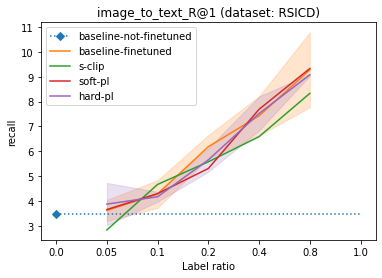

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1184   base   False     UCM      0  None   0.1     NaN  64  0.00005       0.0   

                 metric value             
                         mean  std count  
1184  image_to_text_R@1  9.52  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1550   base   False     UCM     25  None  0.05     NaN  64  0.00005      25.0   
1556   base   False     UCM     25  None  0.10     NaN  64  0.00005      25.0   
1562   base   False     UCM     25  None  0.20     NaN  64  0.00005      25.0   
1568   base   False     UCM     25  None  0.40     NaN  64  0.00005      25.0   
1574   base   False     UCM     25  None  0.80     NaN  64  0.00005      25.0   

                 metric   value                  
                           mean       std count  
1550  image_to_text_R@1   7.998  1.856252     5  
1556  image_to_text_R@1   8.666  0.848870     5  
1562  image_to_text_R@1  10.572  1.661827     5  
1568  image_to_text_R@1  12.096  1.602539     5  
1574  image_to_text_R@1  13.238  2.638990     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                            
10366   ours   False     UCM     25  ot.image  0.05     NaN  128  0.00005   
10372   ours   False     UCM     25  ot.image  0.10     NaN  128  0.00005   
10378   ours   False     UCM     25  ot.image  0.20     NaN  128  0.00005   
10384   ours   False     UCM     25  ot.image  0.40     NaN  128  0.00005   
10390   ours   False     UCM     25  ot.image  0.80     NaN  128  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10366      25.0  image_to_text_R@1   6.19 NaN     1  
10372      25.0  image_to_text_R@1  10.95 NaN     1  
10378      25.0  image_to_text_R@1   9.05 NaN     1  
10384      25.0  image_to_text_R@1  10.95 NaN     1  
10390      25.0  image_to_text_R@1  12.86 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                            
10546   ours   False     UCM     30  soft.text  0.05     NaN  64  0.00005   
10552   ours   False     UCM     30  soft.text  0.10     NaN  64  0.00005   
10558   ours   False     UCM     30  soft.text  0.20     NaN  64  0.00005   
10564   ours   False     UCM     30  soft.text  0.40     NaN  64  0.00005   
10570   ours   False     UCM     30  soft.text  0.80     NaN  64  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10546      30.0  image_to_text_R@1   6.67 NaN     1  
10552      30.0  image_to_text_R@1  12.38 NaN     1  
10558      30.0  image_to_text_R@1   8.57 NaN     1  
10564      30.0  image_to_text_R@1  10.95 NaN     1  
10570      30.0  image_to_text_R@1  13.81 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                            
10336   ours   False     UCM     25  hard.text  0.05     NaN  64  0.00005   
10342   ours   False     UCM     25  hard.text  0.10     NaN  64  0.00005   
10348   ours   False     UCM     25  hard.text  0.20     NaN  64  0.00005   
10354   ours   False     UCM     25  hard.text  0.40     NaN  64  0.00005   
10360   ours   False     UCM     25  hard.text  0.80     NaN  64  0.00005   

      AL.epochs             metric   value                  
                                      mean       std count  
10336      25.0  image_to_text_R@1   7.906  0.724003     5  
10342      25.0  image_to_text_R@1   9.432  1.823916     5  
10348      25.0  image_to_text_R@1  11.240  2.323962     5  
10354      25.0  image_to_text_R@1  12.952  1.086241     5  
10360      25.0  image_to_text_R@1  11.620  0.424853     5

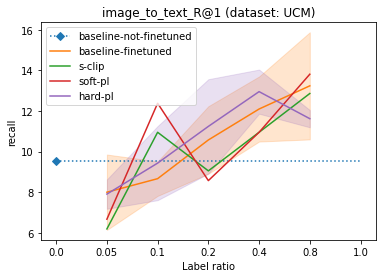

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
740   base   False  Sydney      0  None   0.1     NaN  64  0.00005       0.0   

                metric value             
                        mean  std count  
740  image_to_text_R@1  1.41  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1106   base   False  Sydney     25  None  0.05     NaN  64  0.00005      25.0   
1112   base   False  Sydney     25  None  0.10     NaN  64  0.00005      25.0   
1118   base   False  Sydney     25  None  0.20     NaN  64  0.00005      25.0   
1124   base   False  Sydney     25  None  0.40     NaN  64  0.00005      25.0   
1130   base   False  Sydney     25  None  0.80     NaN  64  0.00005      25.0   

                 metric   value                  
                           mean       std count  
1106  image_to_text_R@1   2.050  0.296648     5  
1112  image_to_text_R@1   3.300  0.576194     5  
1118  image_to_text_R@1   5.032  0.513829     5  
1124  image_to_text_R@1   6.960  1.116714     5  
1130  image_to_text_R@1  12.756  0.662442     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                           
7966   ours   False  Sydney     25  ot.image  0.05     NaN  128  0.00005   
7972   ours   False  Sydney     25  ot.image  0.10     NaN  128  0.00005   
7978   ours   False  Sydney     25  ot.image  0.20     NaN  128  0.00005   
7984   ours   False  Sydney     25  ot.image  0.40     NaN  128  0.00005   
7990   ours   False  Sydney     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric value            
                                   mean std count  
7966      25.0  image_to_text_R@1  1.81 NaN     1  
7972      25.0  image_to_text_R@1  2.01 NaN     1  
7978      25.0  image_to_text_R@1  3.62 NaN     1  
7984      25.0  image_to_text_R@1  6.24 NaN     1  
7990      25.0  image_to_text_R@1  8.45 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
8146   ours   False  Sydney     30  soft.text  0.05     NaN  64  0.00005   
8152   ours   False  Sydney     30  soft.text  0.10     NaN  64  0.00005   
8158   ours   False  Sydney     30  soft.text  0.20     NaN  64  0.00005   
8164   ours   False  Sydney     30  soft.text  0.40     NaN  64  0.00005   
8170   ours   False  Sydney     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric value            
                                   mean std count  
8146      30.0  image_to_text_R@1  2.01 NaN     1  
8152      30.0  image_to_text_R@1  2.01 NaN     1  
8158      30.0  image_to_text_R@1  5.03 NaN     1  
8164      30.0  image_to_text_R@1  6.84 NaN     1  
8170      30.0  image_to_text_R@1  8.65 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
7936   ours   False  Sydney     25  hard.text  0.05     NaN  64  0.00005   
7942   ours   False  Sydney     25  hard.text  0.10     NaN  64  0.00005   
7948   ours   False  Sydney     25  hard.text  0.20     NaN  64  0.00005   
7954   ours   False  Sydney     25  hard.text  0.40     NaN  64  0.00005   
7960   ours   False  Sydney     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value                  
                                    mean       std count  
7936      25.0  image_to_text_R@1  2.334  0.823911     5  
7942      25.0  image_to_text_R@1  3.060  0.167332     5  
7948      25.0  image_to_text_R@1  3.056  0.958348     5  
7954      25.0  image_to_text_R@1  5.554  1.114823     5  
7960      25.0  image_to_text_R@1  7.964  1.171700     5

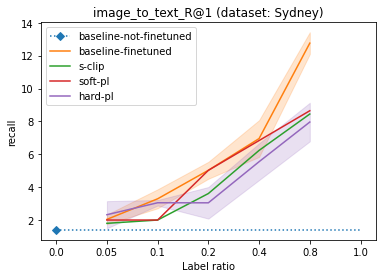

In [19]:
metric = 'image_to_text_R@1'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1184   base   False     UCM      0  None   0.1     NaN  64  0.00005       0.0   

                 metric value             
                         mean  std count  
1184  image_to_text_R@1  9.52  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1550   base   False     UCM     25  None  0.05     NaN  64  0.00005      25.0   
1556   base   False     UCM     25  None  0.10     NaN  64  0.00005      25.0   
1562   base   False     UCM     25  None  0.20     NaN  64  0.00005      25.0   
1568   base   False     UCM     25  None  0.40     NaN  64  0.00005      25.0   
1574   base   False     UCM     25  None  0.80     NaN  64  0.00005      25.0   

                 metric   value                  
                           mean       std count  
1550  image_to_text_R@1   7.998  1.856252     5  
1556  image_to_text_R@1   8.666  0.848870     5  
1562  image_to_text_R@1  10.572  1.661827     5  
1568  image_to_text_R@1  12.096  1.602539     5  
1574  image_to_text_R@1  13.238  2.638990     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                            
10366   ours   False     UCM     25  ot.image  0.05     NaN  128  0.00005   
10372   ours   False     UCM     25  ot.image  0.10     NaN  128  0.00005   
10378   ours   False     UCM     25  ot.image  0.20     NaN  128  0.00005   
10384   ours   False     UCM     25  ot.image  0.40     NaN  128  0.00005   
10390   ours   False     UCM     25  ot.image  0.80     NaN  128  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10366      25.0  image_to_text_R@1   6.19 NaN     1  
10372      25.0  image_to_text_R@1  10.95 NaN     1  
10378      25.0  image_to_text_R@1   9.05 NaN     1  
10384      25.0  image_to_text_R@1  10.95 NaN     1  
10390      25.0  image_to_text_R@1  12.86 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                            
10546   ours   False     UCM     30  soft.text  0.05     NaN  64  0.00005   
10552   ours   False     UCM     30  soft.text  0.10     NaN  64  0.00005   
10558   ours   False     UCM     30  soft.text  0.20     NaN  64  0.00005   
10564   ours   False     UCM     30  soft.text  0.40     NaN  64  0.00005   
10570   ours   False     UCM     30  soft.text  0.80     NaN  64  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10546      30.0  image_to_text_R@1   6.67 NaN     1  
10552      30.0  image_to_text_R@1  12.38 NaN     1  
10558      30.0  image_to_text_R@1   8.57 NaN     1  
10564      30.0  image_to_text_R@1  10.95 NaN     1  
10570      30.0  image_to_text_R@1  13.81 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                            
10336   ours   False     UCM     25  hard.text  0.05     NaN  64  0.00005   
10342   ours   False     UCM     25  hard.text  0.10     NaN  64  0.00005   
10348   ours   False     UCM     25  hard.text  0.20     NaN  64  0.00005   
10354   ours   False     UCM     25  hard.text  0.40     NaN  64  0.00005   
10360   ours   False     UCM     25  hard.text  0.80     NaN  64  0.00005   

      AL.epochs             metric   value                  
                                      mean       std count  
10336      25.0  image_to_text_R@1   7.906  0.724003     5  
10342      25.0  image_to_text_R@1   9.432  1.823916     5  
10348      25.0  image_to_text_R@1  11.240  2.323962     5  
10354      25.0  image_to_text_R@1  12.952  1.086241     5  
10360      25.0  image_to_text_R@1  11.620  0.424853     5

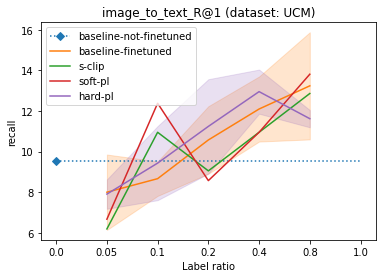

In [20]:
plot_model_comparison(results_dict, metric, 'UCM')

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
740   base   False  Sydney      0  None   0.1     NaN  64  0.00005       0.0   

                metric value             
                        mean  std count  
740  image_to_text_R@1  1.41  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1106   base   False  Sydney     25  None  0.05     NaN  64  0.00005      25.0   
1112   base   False  Sydney     25  None  0.10     NaN  64  0.00005      25.0   
1118   base   False  Sydney     25  None  0.20     NaN  64  0.00005      25.0   
1124   base   False  Sydney     25  None  0.40     NaN  64  0.00005      25.0   
1130   base   False  Sydney     25  None  0.80     NaN  64  0.00005      25.0   

                 metric   value                  
                           mean       std count  
1106  image_to_text_R@1   2.050  0.296648     5  
1112  image_to_text_R@1   3.300  0.576194     5  
1118  image_to_text_R@1   5.032  0.513829     5  
1124  image_to_text_R@1   6.960  1.116714     5  
1130  image_to_text_R@1  12.756  0.662442     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                           
7966   ours   False  Sydney     25  ot.image  0.05     NaN  128  0.00005   
7972   ours   False  Sydney     25  ot.image  0.10     NaN  128  0.00005   
7978   ours   False  Sydney     25  ot.image  0.20     NaN  128  0.00005   
7984   ours   False  Sydney     25  ot.image  0.40     NaN  128  0.00005   
7990   ours   False  Sydney     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric value            
                                   mean std count  
7966      25.0  image_to_text_R@1  1.81 NaN     1  
7972      25.0  image_to_text_R@1  2.01 NaN     1  
7978      25.0  image_to_text_R@1  3.62 NaN     1  
7984      25.0  image_to_text_R@1  6.24 NaN     1  
7990      25.0  image_to_text_R@1  8.45 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
8146   ours   False  Sydney     30  soft.text  0.05     NaN  64  0.00005   
8152   ours   False  Sydney     30  soft.text  0.10     NaN  64  0.00005   
8158   ours   False  Sydney     30  soft.text  0.20     NaN  64  0.00005   
8164   ours   False  Sydney     30  soft.text  0.40     NaN  64  0.00005   
8170   ours   False  Sydney     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric value            
                                   mean std count  
8146      30.0  image_to_text_R@1  2.01 NaN     1  
8152      30.0  image_to_text_R@1  2.01 NaN     1  
8158      30.0  image_to_text_R@1  5.03 NaN     1  
8164      30.0  image_to_text_R@1  6.84 NaN     1  
8170      30.0  image_to_text_R@1  8.65 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
7936   ours   False  Sydney     25  hard.text  0.05     NaN  64  0.00005   
7942   ours   False  Sydney     25  hard.text  0.10     NaN  64  0.00005   
7948   ours   False  Sydney     25  hard.text  0.20     NaN  64  0.00005   
7954   ours   False  Sydney     25  hard.text  0.40     NaN  64  0.00005   
7960   ours   False  Sydney     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value                  
                                    mean       std count  
7936      25.0  image_to_text_R@1  2.334  0.823911     5  
7942      25.0  image_to_text_R@1  3.060  0.167332     5  
7948      25.0  image_to_text_R@1  3.056  0.958348     5  
7954      25.0  image_to_text_R@1  5.554  1.114823     5  
7960      25.0  image_to_text_R@1  7.964  1.171700     5

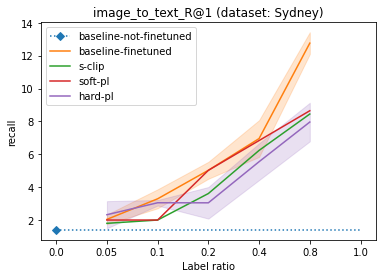

In [21]:
plot_model_comparison(results_dict, metric, 'Sydney')

RSICD-CLS zeroshot-val-top1


method ProbVLM    dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                        
592   base   False  RSICD-CLS      0  None   0.1     NaN  64  0.00005   

    AL.epochs             metric  value             
                                   mean  std count  
592       0.0  zeroshot-val-top1  53.71  0.0     3

method ProbVLM    dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                        
653   base   False  RSICD-CLS     25  None  0.05     NaN  64  0.00005   
654   base   False  RSICD-CLS     25  None  0.10     NaN  64  0.00005   
655   base   False  RSICD-CLS     25  None  0.20     NaN  64  0.00005   
656   base   False  RSICD-CLS     25  None  0.40     NaN  64  0.00005   
657   base   False  RSICD-CLS     25  None  0.80     NaN  64  0.00005   

    AL.epochs             metric   value                  
                                    mean       std count  
653      25.0  zeroshot-val-top1  56.652  1.917008     5  
654      25.0  zeroshot-val-top1  63.916  1.673090     5  
655      25.0  zeroshot-val-top1  72.700  1.399071     5  
656      25.0  zeroshot-val-top1  83.220  1.070047     5  
657      25.0  zeroshot-val-top1  84.592  2.209835     5

method ProbVLM    dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                              
5341   ours   False  RSICD-CLS     25  ot.image  0.05     NaN  128  0.00005   
5342   ours   False  RSICD-CLS     25  ot.image  0.10     NaN  128  0.00005   
5343   ours   False  RSICD-CLS     25  ot.image  0.20     NaN  128  0.00005   
5344   ours   False  RSICD-CLS     25  ot.image  0.40     NaN  128  0.00005   
5345   ours   False  RSICD-CLS     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
5341      25.0  zeroshot-val-top1  54.35 NaN     1  
5342      25.0  zeroshot-val-top1  61.02 NaN     1  
5343      25.0  zeroshot-val-top1  75.75 NaN     1  
5344      25.0  zeroshot-val-top1  83.90 NaN     1  
5345      25.0  zeroshot-val-top1  84.90 NaN     1

method ProbVLM    dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                              
5371   ours   False  RSICD-CLS     30  soft.text  0.05     NaN  64  0.00005   
5372   ours   False  RSICD-CLS     30  soft.text  0.10     NaN  64  0.00005   
5373   ours   False  RSICD-CLS     30  soft.text  0.20     NaN  64  0.00005   
5374   ours   False  RSICD-CLS     30  soft.text  0.40     NaN  64  0.00005   
5375   ours   False  RSICD-CLS     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
5371      30.0  zeroshot-val-top1  55.81 NaN     1  
5372      30.0  zeroshot-val-top1  65.14 NaN     1  
5373      30.0  zeroshot-val-top1  77.77 NaN     1  
5374      30.0  zeroshot-val-top1  82.80 NaN     1  
5375      30.0  zeroshot-val-top1  88.47 NaN     1

method ProbVLM    dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                              
5336   ours   False  RSICD-CLS     25  hard.text  0.05     NaN  64  0.00005   
5337   ours   False  RSICD-CLS     25  hard.text  0.10     NaN  64  0.00005   
5338   ours   False  RSICD-CLS     25  hard.text  0.20     NaN  64  0.00005   
5339   ours   False  RSICD-CLS     25  hard.text  0.40     NaN  64  0.00005   
5340   ours   False  RSICD-CLS     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
5336      25.0  zeroshot-val-top1  59.012  1.691204     5  
5337      25.0  zeroshot-val-top1  65.214  2.675253     5  
5338      25.0  zeroshot-val-top1  75.314  0.452526     5  
5339      25.0  zeroshot-val-top1  82.086  2.044170     5  
5340      25.0  zeroshot-val-top1  84.888  0.979398     5

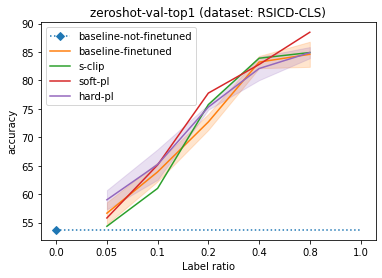

UCM-CLS zeroshot-val-top1


method ProbVLM  dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                       
1628   base   False  UCM-CLS      0  None   0.1     NaN  64  0.00005   

     AL.epochs             metric  value                      
                                    mean           std count  
1628       0.0  zeroshot-val-top1  49.05  8.702336e-15     3

method ProbVLM  dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                       
1689   base   False  UCM-CLS     25  None  0.05     NaN  64  0.00005   
1690   base   False  UCM-CLS     25  None  0.10     NaN  64  0.00005   
1691   base   False  UCM-CLS     25  None  0.20     NaN  64  0.00005   
1692   base   False  UCM-CLS     25  None  0.40     NaN  64  0.00005   
1693   base   False  UCM-CLS     25  None  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
1689      25.0  zeroshot-val-top1  53.332  2.104904     5  
1690      25.0  zeroshot-val-top1  57.712  1.974062     5  
1691      25.0  zeroshot-val-top1  68.476  1.361591     5  
1692      25.0  zeroshot-val-top1  71.238  2.924691     5  
1693      25.0  zeroshot-val-top1  76.284  1.827438     5

method ProbVLM  dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                             
10941   ours   False  UCM-CLS     25  ot.image  0.05     NaN  128  0.00005   
10942   ours   False  UCM-CLS     25  ot.image  0.10     NaN  128  0.00005   
10943   ours   False  UCM-CLS     25  ot.image  0.20     NaN  128  0.00005   
10944   ours   False  UCM-CLS     25  ot.image  0.40     NaN  128  0.00005   
10945   ours   False  UCM-CLS     25  ot.image  0.80     NaN  128  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10941      25.0  zeroshot-val-top1  59.05 NaN     1  
10942      25.0  zeroshot-val-top1  65.71 NaN     1  
10943      25.0  zeroshot-val-top1  70.00 NaN     1  
10944      25.0  zeroshot-val-top1  69.52 NaN     1  
10945      25.0  zeroshot-val-top1  73.81 NaN     1

method ProbVLM  dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                             
10971   ours   False  UCM-CLS     30  soft.text  0.05     NaN  64  0.00005   
10972   ours   False  UCM-CLS     30  soft.text  0.10     NaN  64  0.00005   
10973   ours   False  UCM-CLS     30  soft.text  0.20     NaN  64  0.00005   
10974   ours   False  UCM-CLS     30  soft.text  0.40     NaN  64  0.00005   
10975   ours   False  UCM-CLS     30  soft.text  0.80     NaN  64  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10971      30.0  zeroshot-val-top1  50.95 NaN     1  
10972      30.0  zeroshot-val-top1  69.05 NaN     1  
10973      30.0  zeroshot-val-top1  71.43 NaN     1  
10974      30.0  zeroshot-val-top1  71.43 NaN     1  
10975      30.0  zeroshot-val-top1  71.43 NaN     1

method ProbVLM  dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                             
10936   ours   False  UCM-CLS     25  hard.text  0.05     NaN  64  0.00005   
10937   ours   False  UCM-CLS     25  hard.text  0.10     NaN  64  0.00005   
10938   ours   False  UCM-CLS     25  hard.text  0.20     NaN  64  0.00005   
10939   ours   False  UCM-CLS     25  hard.text  0.40     NaN  64  0.00005   
10940   ours   False  UCM-CLS     25  hard.text  0.80     NaN  64  0.00005   

      AL.epochs             metric   value                  
                                      mean       std count  
10936      25.0  zeroshot-val-top1  51.618  5.267326     5  
10937      25.0  zeroshot-val-top1  62.948  2.702086     5  
10938      25.0  zeroshot-val-top1  67.906  2.513102     5  
10939      25.0  zeroshot-val-top1  73.904  3.707024     5  
10940      25.0  zeroshot-val-top1  69.716  1.489221     5

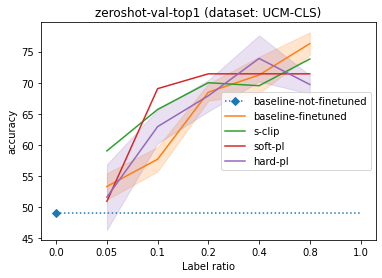

WHU-RS19 zeroshot-val-top1


method ProbVLM   dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                        
1702   base   False  WHU-RS19      0  None   0.1     NaN  64  0.00005   

     AL.epochs             metric  value             
                                    mean  std count  
1702       0.0  zeroshot-val-top1  68.56  0.0     3

method ProbVLM   dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                        
1763   base   False  WHU-RS19     25  None  0.05     NaN  64  0.00005   
1764   base   False  WHU-RS19     25  None  0.10     NaN  64  0.00005   
1765   base   False  WHU-RS19     25  None  0.20     NaN  64  0.00005   
1766   base   False  WHU-RS19     25  None  0.40     NaN  64  0.00005   
1767   base   False  WHU-RS19     25  None  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
1763      25.0  zeroshot-val-top1  72.816  2.298027     5  
1764      25.0  zeroshot-val-top1  81.810  1.640290     5  
1765      25.0  zeroshot-val-top1  86.944  2.460961     5  
1766      25.0  zeroshot-val-top1  93.252  0.540759     5  
1767      25.0  zeroshot-val-top1  94.926  0.692120     5

method ProbVLM   dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                              
11341   ours   False  WHU-RS19     25  ot.image  0.05     NaN  128  0.00005   
11342   ours   False  WHU-RS19     25  ot.image  0.10     NaN  128  0.00005   
11343   ours   False  WHU-RS19     25  ot.image  0.20     NaN  128  0.00005   
11344   ours   False  WHU-RS19     25  ot.image  0.40     NaN  128  0.00005   
11345   ours   False  WHU-RS19     25  ot.image  0.80     NaN  128  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
11341      25.0  zeroshot-val-top1  78.71 NaN     1  
11342      25.0  zeroshot-val-top1  83.18 NaN     1  
11343      25.0  zeroshot-val-top1  92.64 NaN     1  
11344      25.0  zeroshot-val-top1  96.02 NaN     1  
11345      25.0  zeroshot-val-top1  97.31 NaN     1

method ProbVLM   dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                              
11371   ours   False  WHU-RS19     30  soft.text  0.05     NaN  64  0.00005   
11372   ours   False  WHU-RS19     30  soft.text  0.10     NaN  64  0.00005   
11373   ours   False  WHU-RS19     30  soft.text  0.20     NaN  64  0.00005   
11374   ours   False  WHU-RS19     30  soft.text  0.40     NaN  64  0.00005   
11375   ours   False  WHU-RS19     30  soft.text  0.80     NaN  64  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
11371      30.0  zeroshot-val-top1  75.12 NaN     1  
11372      30.0  zeroshot-val-top1  85.07 NaN     1  
11373      30.0  zeroshot-val-top1  93.13 NaN     1  
11374      30.0  zeroshot-val-top1  95.12 NaN     1  
11375      30.0  zeroshot-val-top1  97.41 NaN     1

method ProbVLM   dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                              
11336   ours   False  WHU-RS19     25  hard.text  0.05     NaN  64  0.00005   
11337   ours   False  WHU-RS19     25  hard.text  0.10     NaN  64  0.00005   
11338   ours   False  WHU-RS19     25  hard.text  0.20     NaN  64  0.00005   
11339   ours   False  WHU-RS19     25  hard.text  0.40     NaN  64  0.00005   
11340   ours   False  WHU-RS19     25  hard.text  0.80     NaN  64  0.00005   

      AL.epochs             metric   value                  
                                      mean       std count  
11336      25.0  zeroshot-val-top1  76.616  3.076244     5  
11337      25.0  zeroshot-val-top1  84.160  1.241813     5  
11338      25.0  zeroshot-val-top1  91.182  1.490107     5  
11339      25.0  zeroshot-val-top1  93.534  0.952119     5  
11340      25.0  zeroshot-val-top1  97.134  1.287975     5

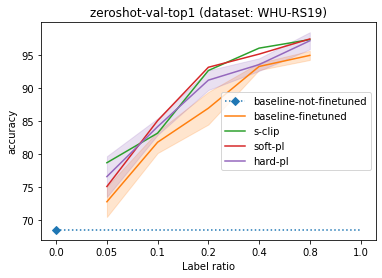

RSSCN7 zeroshot-val-top1


method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
666   base   False  RSSCN7      0  None   0.1     NaN  64  0.00005       0.0   

                metric value             
                        mean  std count  
666  zeroshot-val-top1  55.0  0.0     3

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
727   base   False  RSSCN7     25  None  0.05     NaN  64  0.00005      25.0   
728   base   False  RSSCN7     25  None  0.10     NaN  64  0.00005      25.0   
729   base   False  RSSCN7     25  None  0.20     NaN  64  0.00005      25.0   
730   base   False  RSSCN7     25  None  0.40     NaN  64  0.00005      25.0   
731   base   False  RSSCN7     25  None  0.80     NaN  64  0.00005      25.0   

                metric   value                  
                          mean       std count  
727  zeroshot-val-top1  54.836  1.017561     5  
728  zeroshot-val-top1  63.492  3.774284     5  
729  zeroshot-val-top1  65.036  1.538597     5  
730  zeroshot-val-top1  64.236  2.246526     5  
731  zeroshot-val-top1  66.378  3.602835     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                           
5741   ours   False  RSSCN7     25  ot.image  0.05     NaN  128  0.00005   
5742   ours   False  RSSCN7     25  ot.image  0.10     NaN  128  0.00005   
5743   ours   False  RSSCN7     25  ot.image  0.20     NaN  128  0.00005   
5744   ours   False  RSSCN7     25  ot.image  0.40     NaN  128  0.00005   
5745   ours   False  RSSCN7     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
5741      25.0  zeroshot-val-top1  57.89 NaN     1  
5742      25.0  zeroshot-val-top1  59.71 NaN     1  
5743      25.0  zeroshot-val-top1  71.46 NaN     1  
5744      25.0  zeroshot-val-top1  63.57 NaN     1  
5745      25.0  zeroshot-val-top1  66.07 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
5771   ours   False  RSSCN7     30  soft.text  0.05     NaN  64  0.00005   
5772   ours   False  RSSCN7     30  soft.text  0.10     NaN  64  0.00005   
5773   ours   False  RSSCN7     30  soft.text  0.20     NaN  64  0.00005   
5774   ours   False  RSSCN7     30  soft.text  0.40     NaN  64  0.00005   
5775   ours   False  RSSCN7     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
5771      30.0  zeroshot-val-top1  55.75 NaN     1  
5772      30.0  zeroshot-val-top1  59.71 NaN     1  
5773      30.0  zeroshot-val-top1  61.86 NaN     1  
5774      30.0  zeroshot-val-top1  66.68 NaN     1  
5775      30.0  zeroshot-val-top1  61.32 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
5736   ours   False  RSSCN7     25  hard.text  0.05     NaN  64  0.00005   
5737   ours   False  RSSCN7     25  hard.text  0.10     NaN  64  0.00005   
5738   ours   False  RSSCN7     25  hard.text  0.20     NaN  64  0.00005   
5739   ours   False  RSSCN7     25  hard.text  0.40     NaN  64  0.00005   
5740   ours   False  RSSCN7     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
5736      25.0  zeroshot-val-top1  56.786  3.571733     5  
5737      25.0  zeroshot-val-top1  58.944  1.496489     5  
5738      25.0  zeroshot-val-top1  64.956  3.422306     5  
5739      25.0  zeroshot-val-top1  66.790  1.980795     5  
5740      25.0  zeroshot-val-top1  64.002  0.720014     5

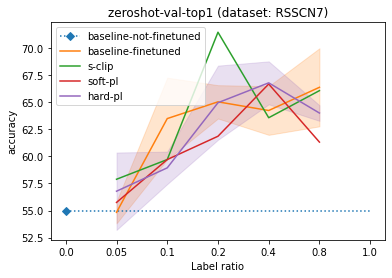

AID zeroshot-val-top1


method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                             
0   base   False     AID      0  None   0.1     NaN  64  0.00005       0.0   

              metric  value             
                       mean  std count  
0  zeroshot-val-top1  52.82  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                              
61   base   False     AID     25  None  0.05     NaN  64  0.00005      25.0   
62   base   False     AID     25  None  0.10     NaN  64  0.00005      25.0   
63   base   False     AID     25  None  0.20     NaN  64  0.00005      25.0   
64   base   False     AID     25  None  0.40     NaN  64  0.00005      25.0   
65   base   False     AID     25  None  0.80     NaN  64  0.00005      25.0   

               metric   value                  
                         mean       std count  
61  zeroshot-val-top1  61.106  2.422329     5  
62  zeroshot-val-top1  68.166  1.051038     5  
63  zeroshot-val-top1  77.632  1.239706     5  
64  zeroshot-val-top1  86.402  1.271739     5  
65  zeroshot-val-top1  89.808  0.570500     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                           
2141   ours   False     AID     25  ot.image  0.05     NaN  128  0.00005   
2142   ours   False     AID     25  ot.image  0.10     NaN  128  0.00005   
2143   ours   False     AID     25  ot.image  0.20     NaN  128  0.00005   
2144   ours   False     AID     25  ot.image  0.40     NaN  128  0.00005   
2145   ours   False     AID     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
2141      25.0  zeroshot-val-top1  61.63 NaN     1  
2142      25.0  zeroshot-val-top1  70.32 NaN     1  
2143      25.0  zeroshot-val-top1  82.34 NaN     1  
2144      25.0  zeroshot-val-top1  88.44 NaN     1  
2145      25.0  zeroshot-val-top1  90.99 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
2171   ours   False     AID     30  soft.text  0.05     NaN  64  0.00005   
2172   ours   False     AID     30  soft.text  0.10     NaN  64  0.00005   
2173   ours   False     AID     30  soft.text  0.20     NaN  64  0.00005   
2174   ours   False     AID     30  soft.text  0.40     NaN  64  0.00005   
2175   ours   False     AID     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
2171      30.0  zeroshot-val-top1  59.65 NaN     1  
2172      30.0  zeroshot-val-top1  73.33 NaN     1  
2173      30.0  zeroshot-val-top1  84.50 NaN     1  
2174      30.0  zeroshot-val-top1  89.59 NaN     1  
2175      30.0  zeroshot-val-top1  93.63 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
2136   ours   False     AID     25  hard.text  0.05     NaN  64  0.00005   
2137   ours   False     AID     25  hard.text  0.10     NaN  64  0.00005   
2138   ours   False     AID     25  hard.text  0.20     NaN  64  0.00005   
2139   ours   False     AID     25  hard.text  0.40     NaN  64  0.00005   
2140   ours   False     AID     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
2136      25.0  zeroshot-val-top1  62.148  1.000335     5  
2137      25.0  zeroshot-val-top1  71.790  0.514296     5  
2138      25.0  zeroshot-val-top1  81.180  0.213307     5  
2139      25.0  zeroshot-val-top1  87.206  1.901534     5  
2140      25.0  zeroshot-val-top1  90.238  0.787096     5

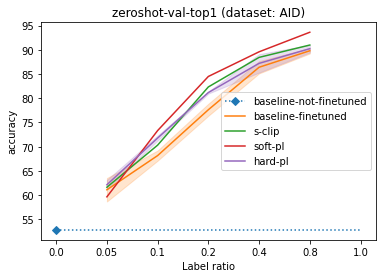

RESISC45 zeroshot-val-top1


method ProbVLM   dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
74   base   False  RESISC45      0  None   0.1     NaN  64  0.00005       0.0   

               metric  value             
                        mean  std count  
74  zeroshot-val-top1  48.71  0.0     2

method ProbVLM   dataset epochs    PL ratio AL.iter  bs       lr  \
                                                                       
135   base   False  RESISC45     25  None  0.05     NaN  64  0.00005   
136   base   False  RESISC45     25  None  0.10     NaN  64  0.00005   
137   base   False  RESISC45     25  None  0.20     NaN  64  0.00005   
138   base   False  RESISC45     25  None  0.40     NaN  64  0.00005   
139   base   False  RESISC45     25  None  0.80     NaN  64  0.00005   

    AL.epochs             metric   value                  
                                    mean       std count  
135      25.0  zeroshot-val-top1  31.408  1.490493     5  
136      25.0  zeroshot-val-top1  32.692  1.019348     5  
137      25.0  zeroshot-val-top1  38.208  1.053931     5  
138      25.0  zeroshot-val-top1  40.236  1.704503     5  
139      25.0  zeroshot-val-top1  43.876  1.197969     5

method ProbVLM   dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                             
2541   ours   False  RESISC45     25  ot.image  0.05     NaN  128  0.00005   
2542   ours   False  RESISC45     25  ot.image  0.10     NaN  128  0.00005   
2543   ours   False  RESISC45     25  ot.image  0.20     NaN  128  0.00005   
2544   ours   False  RESISC45     25  ot.image  0.40     NaN  128  0.00005   
2545   ours   False  RESISC45     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
2541      25.0  zeroshot-val-top1  30.70 NaN     1  
2542      25.0  zeroshot-val-top1  34.23 NaN     1  
2543      25.0  zeroshot-val-top1  39.68 NaN     1  
2544      25.0  zeroshot-val-top1  46.61 NaN     1  
2545      25.0  zeroshot-val-top1  45.52 NaN     1

method ProbVLM   dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                             
2571   ours   False  RESISC45     30  soft.text  0.05     NaN  64  0.00005   
2572   ours   False  RESISC45     30  soft.text  0.10     NaN  64  0.00005   
2573   ours   False  RESISC45     30  soft.text  0.20     NaN  64  0.00005   
2574   ours   False  RESISC45     30  soft.text  0.40     NaN  64  0.00005   
2575   ours   False  RESISC45     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
2571      30.0  zeroshot-val-top1  28.54 NaN     1  
2572      30.0  zeroshot-val-top1  39.09 NaN     1  
2573      30.0  zeroshot-val-top1  44.46 NaN     1  
2574      30.0  zeroshot-val-top1  46.64 NaN     1  
2575      30.0  zeroshot-val-top1  46.40 NaN     1

method ProbVLM   dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                             
2536   ours   False  RESISC45     25  hard.text  0.05     NaN  64  0.00005   
2537   ours   False  RESISC45     25  hard.text  0.10     NaN  64  0.00005   
2538   ours   False  RESISC45     25  hard.text  0.20     NaN  64  0.00005   
2539   ours   False  RESISC45     25  hard.text  0.40     NaN  64  0.00005   
2540   ours   False  RESISC45     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
2536      25.0  zeroshot-val-top1  29.532  1.536219     5  
2537      25.0  zeroshot-val-top1  35.312  0.492818     5  
2538      25.0  zeroshot-val-top1  40.044  1.627108     5  
2539      25.0  zeroshot-val-top1  44.900  1.230406     5  
2540      25.0  zeroshot-val-top1  45.998  0.375659     5

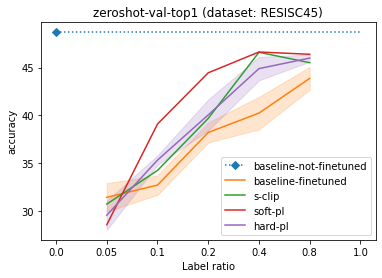

In [22]:
metric = 'zeroshot-val-top1'
datasets = ["RSICD-CLS", "UCM-CLS", "WHU-RS19", "RSSCN7", "AID", "RESISC45"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
153   base   False   RSICD      0  None   0.1     NaN  64  0.00005       0.0   

                metric  value             
                         mean  std count  
153  text_to_image_R@5  14.27  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
519   base   False   RSICD     25  None  0.05     NaN  64  0.00005      25.0   
525   base   False   RSICD     25  None  0.10     NaN  64  0.00005      25.0   
531   base   False   RSICD     25  None  0.20     NaN  64  0.00005      25.0   
537   base   False   RSICD     25  None  0.40     NaN  64  0.00005      25.0   
543   base   False   RSICD     25  None  0.80     NaN  64  0.00005      25.0   

                metric   value                  
                          mean       std count  
519  text_to_image_R@5  13.122  0.420678     5  
525  text_to_image_R@5  16.690  0.939920     5  
531  text_to_image_R@5  20.806  1.018052     5  
537  text_to_image_R@5  24.904  0.638968     5  
543  text_to_image_R@5  29.532  0.979525     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                           
4771   ours   False   RSICD     25  ot.image  0.05     NaN  128  0.00005   
4777   ours   False   RSICD     25  ot.image  0.10     NaN  128  0.00005   
4783   ours   False   RSICD     25  ot.image  0.20     NaN  128  0.00005   
4789   ours   False   RSICD     25  ot.image  0.40     NaN  128  0.00005   
4795   ours   False   RSICD     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
4771      25.0  text_to_image_R@5  13.45 NaN     1  
4777      25.0  text_to_image_R@5  18.66 NaN     1  
4783      25.0  text_to_image_R@5  20.49 NaN     1  
4789      25.0  text_to_image_R@5  25.07 NaN     1  
4795      25.0  text_to_image_R@5  30.28 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
4951   ours   False   RSICD     30  soft.text  0.05     NaN  64  0.00005   
4957   ours   False   RSICD     30  soft.text  0.10     NaN  64  0.00005   
4963   ours   False   RSICD     30  soft.text  0.20     NaN  64  0.00005   
4969   ours   False   RSICD     30  soft.text  0.40     NaN  64  0.00005   
4975   ours   False   RSICD     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
4951      30.0  text_to_image_R@5  13.63 NaN     1  
4957      30.0  text_to_image_R@5  19.40 NaN     1  
4963      30.0  text_to_image_R@5  21.59 NaN     1  
4969      30.0  text_to_image_R@5  24.98 NaN     1  
4975      30.0  text_to_image_R@5  30.83 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
4741   ours   False   RSICD     25  hard.text  0.05     NaN  64  0.00005   
4747   ours   False   RSICD     25  hard.text  0.10     NaN  64  0.00005   
4753   ours   False   RSICD     25  hard.text  0.20     NaN  64  0.00005   
4759   ours   False   RSICD     25  hard.text  0.40     NaN  64  0.00005   
4765   ours   False   RSICD     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
4741      25.0  text_to_image_R@5  13.630  0.606795     5  
4747      25.0  text_to_image_R@5  17.988  1.053812     5  
4753      25.0  text_to_image_R@5  20.258  0.612021     5  
4759      25.0  text_to_image_R@5  25.616  0.849723     5  
4765      25.0  text_to_image_R@5  30.248  0.532184     5

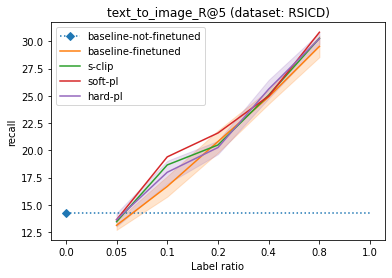

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1189   base   False     UCM      0  None   0.1     NaN  64  0.00005       0.0   

                 metric  value             
                          mean  std count  
1189  text_to_image_R@5  31.43  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1555   base   False     UCM     25  None  0.05     NaN  64  0.00005      25.0   
1561   base   False     UCM     25  None  0.10     NaN  64  0.00005      25.0   
1567   base   False     UCM     25  None  0.20     NaN  64  0.00005      25.0   
1573   base   False     UCM     25  None  0.40     NaN  64  0.00005      25.0   
1579   base   False     UCM     25  None  0.80     NaN  64  0.00005      25.0   

                 metric   value                  
                           mean       std count  
1555  text_to_image_R@5  35.142  3.341118     5  
1561  text_to_image_R@5  38.096  1.814657     5  
1567  text_to_image_R@5  48.666  1.033697     5  
1573  text_to_image_R@5  50.666  1.735578     5  
1579  text_to_image_R@5  55.334  1.824179     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                            
10371   ours   False     UCM     25  ot.image  0.05     NaN  128  0.00005   
10377   ours   False     UCM     25  ot.image  0.10     NaN  128  0.00005   
10383   ours   False     UCM     25  ot.image  0.20     NaN  128  0.00005   
10389   ours   False     UCM     25  ot.image  0.40     NaN  128  0.00005   
10395   ours   False     UCM     25  ot.image  0.80     NaN  128  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10371      25.0  text_to_image_R@5  38.10 NaN     1  
10377      25.0  text_to_image_R@5  42.38 NaN     1  
10383      25.0  text_to_image_R@5  51.43 NaN     1  
10389      25.0  text_to_image_R@5  51.90 NaN     1  
10395      25.0  text_to_image_R@5  56.19 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                            
10551   ours   False     UCM     30  soft.text  0.05     NaN  64  0.00005   
10557   ours   False     UCM     30  soft.text  0.10     NaN  64  0.00005   
10563   ours   False     UCM     30  soft.text  0.20     NaN  64  0.00005   
10569   ours   False     UCM     30  soft.text  0.40     NaN  64  0.00005   
10575   ours   False     UCM     30  soft.text  0.80     NaN  64  0.00005   

      AL.epochs             metric  value            
                                     mean std count  
10551      30.0  text_to_image_R@5  33.33 NaN     1  
10557      30.0  text_to_image_R@5  44.76 NaN     1  
10563      30.0  text_to_image_R@5  45.71 NaN     1  
10569      30.0  text_to_image_R@5  50.48 NaN     1  
10575      30.0  text_to_image_R@5  59.05 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                            
10341   ours   False     UCM     25  hard.text  0.05     NaN  64  0.00005   
10347   ours   False     UCM     25  hard.text  0.10     NaN  64  0.00005   
10353   ours   False     UCM     25  hard.text  0.20     NaN  64  0.00005   
10359   ours   False     UCM     25  hard.text  0.40     NaN  64  0.00005   
10365   ours   False     UCM     25  hard.text  0.80     NaN  64  0.00005   

      AL.epochs             metric   value                  
                                      mean       std count  
10341      25.0  text_to_image_R@5  35.430  3.755210     5  
10347      25.0  text_to_image_R@5  43.906  3.390403     5  
10353      25.0  text_to_image_R@5  48.476  3.202246     5  
10359      25.0  text_to_image_R@5  53.998  3.096784     5  
10365      25.0  text_to_image_R@5  59.808  2.553590     5

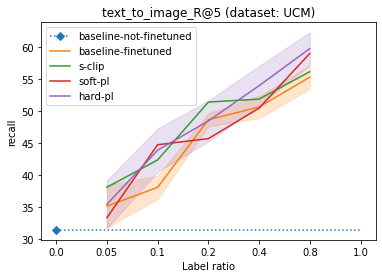

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                               
745   base   False  Sydney      0  None   0.1     NaN  64  0.00005       0.0   

                metric  value             
                         mean  std count  
745  text_to_image_R@5  10.66  0.0     2

method ProbVLM dataset epochs    PL ratio AL.iter  bs       lr AL.epochs  \
                                                                                
1111   base   False  Sydney     25  None  0.05     NaN  64  0.00005      25.0   
1117   base   False  Sydney     25  None  0.10     NaN  64  0.00005      25.0   
1123   base   False  Sydney     25  None  0.20     NaN  64  0.00005      25.0   
1129   base   False  Sydney     25  None  0.40     NaN  64  0.00005      25.0   
1135   base   False  Sydney     25  None  0.80     NaN  64  0.00005      25.0   

                 metric   value                  
                           mean       std count  
1111  text_to_image_R@5  10.746  0.677370     5  
1117  text_to_image_R@5  14.406  1.293940     5  
1123  text_to_image_R@5  18.350  2.141775     5  
1129  text_to_image_R@5  27.044  1.087764     5  
1135  text_to_image_R@5  36.578  1.041091     5

method ProbVLM dataset epochs        PL ratio AL.iter   bs       lr  \
                                                                           
7971   ours   False  Sydney     25  ot.image  0.05     NaN  128  0.00005   
7977   ours   False  Sydney     25  ot.image  0.10     NaN  128  0.00005   
7983   ours   False  Sydney     25  ot.image  0.20     NaN  128  0.00005   
7989   ours   False  Sydney     25  ot.image  0.40     NaN  128  0.00005   
7995   ours   False  Sydney     25  ot.image  0.80     NaN  128  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
7971      25.0  text_to_image_R@5   9.26 NaN     1  
7977      25.0  text_to_image_R@5  13.28 NaN     1  
7983      25.0  text_to_image_R@5  16.50 NaN     1  
7989      25.0  text_to_image_R@5  24.75 NaN     1  
7995      25.0  text_to_image_R@5  31.39 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
8151   ours   False  Sydney     30  soft.text  0.05     NaN  64  0.00005   
8157   ours   False  Sydney     30  soft.text  0.10     NaN  64  0.00005   
8163   ours   False  Sydney     30  soft.text  0.20     NaN  64  0.00005   
8169   ours   False  Sydney     30  soft.text  0.40     NaN  64  0.00005   
8175   ours   False  Sydney     30  soft.text  0.80     NaN  64  0.00005   

     AL.epochs             metric  value            
                                    mean std count  
8151      30.0  text_to_image_R@5  10.46 NaN     1  
8157      30.0  text_to_image_R@5  15.29 NaN     1  
8163      30.0  text_to_image_R@5  16.50 NaN     1  
8169      30.0  text_to_image_R@5  21.13 NaN     1  
8175      30.0  text_to_image_R@5  28.37 NaN     1

method ProbVLM dataset epochs         PL ratio AL.iter  bs       lr  \
                                                                           
7941   ours   False  Sydney     25  hard.text  0.05     NaN  64  0.00005   
7947   ours   False  Sydney     25  hard.text  0.10     NaN  64  0.00005   
7953   ours   False  Sydney     25  hard.text  0.20     NaN  64  0.00005   
7959   ours   False  Sydney     25  hard.text  0.40     NaN  64  0.00005   
7965   ours   False  Sydney     25  hard.text  0.80     NaN  64  0.00005   

     AL.epochs             metric   value                  
                                     mean       std count  
7941      25.0  text_to_image_R@5   9.656  0.752350     5  
7947      25.0  text_to_image_R@5  12.876  0.493994     5  
7953      25.0  text_to_image_R@5  16.016  0.848664     5  
7959      25.0  text_to_image_R@5  21.328  1.865508     5  
7965      25.0  text_to_image_R@5  26.200  0.089443     5

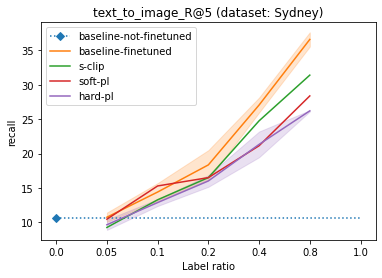

In [23]:
metric = 'text_to_image_R@5'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)